In [1]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import GridWorld_env
from replay_buffer import ReplayBuffer
import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

In [2]:
class Vanilla_DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(Vanilla_DQN, self).__init__()
               
        self.conv1 = nn.Conv3d(3, 29, 3, 1, 1)
        
        self.conv2 = nn.Conv3d(32, 67, 3, 1, 1)
        
        self.fc1 = nn.Linear((64 + 3*2)*input_dim * input_dim * input_dim, 1024)
        
        self.actions = nn.Linear(1024, action_dim)
        self.advantage = nn.Linear(1024, 1)
    def forward(self, x):
        original_state = x
               
        x = self.conv1(x)
        
        x = torch.cat([x, original_state], dim=1)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = torch.cat([x, original_state], dim=1)
        
        x = F.relu(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)
        actions = self.actions(x)
        
        return actions


In [3]:
n_actions = 8
env = gym.make("GridWorld_env/GridWorld", dimension_size=4, path="test_targets")
env.reset()

policy_net = Vanilla_DQN(4, 8)
target_net = Vanilla_DQN(4, 8)

c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [4]:
policy_net = torch.load("../dqn_models/vanilla/vanilla_dqn_policy.pt")
target_net = torch.load("../dqn_models/vanilla/vanilla_dqn_target.pt")


In [5]:
def select_action(state, greedy = False):
    
    with torch.no_grad():
        return policy_net(state).max(1).indices.view(1,1)
        
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

KeyboardInterrupt: 

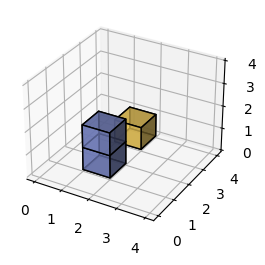

In [8]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(state, greedy = True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    state = next_state
    if terminated or truncated:
        break
    env.unwrapped.render()
    display.clear_output(wait=True)

    
